###  installing Packages

In [1]:
#!pip install transformers
#!pip install spacy
#!python -m spacy download ru_core_news_sm

In [2]:
!wget https://raw.githubusercontent.com/Lojaleto/loader/main/loader.py
!wget https://github.com/Lojaleto/VK_Cup_2022_quali/raw/main/bert.py

In [3]:
import pandas as pd
import numpy as np
import torch
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns

from spacy.lang.ru.examples import sentences 
from loader import download
from bert import BertClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

### get data

In [4]:
download('https://github.com/Lojaleto/VK_Cup_2022_quali/raw/main/subsets/VK_Cup_2022_quali/lemma.csv',
         './subsets/VK_Cup_2022_quali/lemma.csv')
download('https://github.com/Lojaleto/VK_Cup_2022_quali/raw/main/subsets/VK_Cup_2022_quali/lemma_test.csv',
         './subsets/VK_Cup_2022_quali/lemma_test.csv')
download('https://github.com/Lojaleto/VK_Cup_2022_quali/raw/main/datasets/VK_Cup_2022_quali/train.csv',
         './datasets/VK_Cup_2022_quali/train.csv')
download('https://github.com/Lojaleto/VK_Cup_2022_quali/raw/main/datasets/VK_Cup_2022_quali/test.csv',
         './datasets/VK_Cup_2022_quali/test.csv')
download('https://github.com/Lojaleto/VK_Cup_2022_quali/raw/main/datasets/VK_Cup_2022_quali/sample_submission.csv',
         './datasets/VK_Cup_2022_quali/sample_submission.csv')
download('https://github.com/Lojaleto/VK_Cup_2022_quali/raw/main/subsets/VK_Cup_2022_quali/bert.pt',
         './subsets/VK_Cup_2022_quali/bert.pt')


[*] lemma.csv - done                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [5]:
df = {}

#df["train"] = pd.read_csv('./datasets/VK_Cup_2022_quali/train.csv')
#df["test"] = pd.read_csv('./datasets/VK_Cup_2022_quali/test.csv')
df["sample_submission"]  = pd.read_csv('./datasets/VK_Cup_2022_quali/sample_submission.csv')


### lemmatization

In [6]:
'''
nlp = spacy.load('ru_core_web_sm', disable=['parser', 'ner'])
def spacy_fn(sentence):
    doc = nlp(re.sub(r'[^0-9a-zA-Zа-яА-ЯёЁ]', ' ', sentence).lower())
    return " ".join([token.lemma_ for token in doc])
    
df["train"]['text'] = df["train"]['text'].apply(lambda x: spacy_fn(x))
df["train"].to_csv('./subsets/VK_Cup_2022_quali/lemma.csv', index=False)

df["test"]['text'] = df["test"]['text'].apply(lambda x: spacy_fn(x))
df["test"].to_csv('./subsets/VK_Cup_2022_quali/lemma_test.csv', index=False)
'''
pass

#загрузим уже лемматизированные данные
df["train"] = pd.read_csv('./subsets/VK_Cup_2022_quali/lemma.csv')
df["test"] = pd.read_csv('./subsets/VK_Cup_2022_quali/lemma_test.csv')


### initialize BERT classifier

In [7]:
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=13,
        epochs=33,
        model_save_path='./subsets/VK_Cup_2022_quali/bert.pt'
)


In [8]:
keys_target = {'athletics':   0,
               'autosport':   1,
               'basketball':  2,
               'boardgames':  3,
               'esport':      4,
               'extreme':     5,
               'football':    6,
               'hockey':      7,
               'martial_arts':8,
               'motosport':   9,
               'tennis':      10,
               'volleyball':  11,
               'winter_sport':12}

In [9]:
features = df["train"].drop('category', axis=1)
target = df["train"].drop('text', axis=1)

target['category'] = target['category'].apply(lambda x: keys_target[x])

X = {}
y = {}

X["train"], X["valid"], y["train"], y["valid"] = train_test_split(features, target, test_size=0.3,
                                                                stratify=target, random_state=12345)
X["valid"], X["test"], y["valid"], y["test"] = train_test_split(features, target, test_size=0.2,
                                                                stratify=target, random_state=12345)

display(pd.DataFrame([[X["train"].shape, X["valid"].shape, X["test"].shape],
                      [y["train"].shape, y["valid"].shape, y["test"].shape]],
                     columns=['train', 'valid', 'test'],
                     index=['X', 'y']))


,train,valid,test
X,"(27118, 2)","(30992, 2)","(7748, 2)"
y,"(27118, 2)","(30992, 2)","(7748, 2)"


### prepare data and helpers for train and evlauation

In [10]:
classifier.preparation(
        X_train=list(X["train"]['text']),
        y_train=list(y["train"]['category']),
        X_valid=list(X["valid"]['text']),
        y_valid=list(y["valid"]['category'])
    )


### train loop

In [11]:
#classifier.train()

### check test data

In [12]:
#from shutil import copyfile
#copyfile('./subsets/VK_Cup_2022_quali/bert.pt', './drive/MyDrive/bert.pt')

In [13]:
#загрузим уже дообученную модель
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        model_save_path='./subsets/VK_Cup_2022_quali/bert.pt',
        model_load=True
)


### prediction

рассмотрим как должен выглядеть результат, однако нужно ещё провести отсечение внекатегориальных предсказаний, а для этого нам нужны правильные ответы.<br />
мы не можем взять метрики от теста, потому что не знаем правильного ответа.<br />
в тестовом датасете нет категорий.<br />
это должно было происходить на базе серверов VKcup, а мы только отправляли предсказания и получали результат.<br />
выполним хотя бы для тестовой выборки, которую мы подготовили из тренеровочного датасета, чтобы понять механизм.

In [14]:
df["train_test"] = X["test"]
df["train_test"]['category'] = y["test"]['category']
df["train_test"] = df["train_test"][['oid', 'category', 'text']]


In [15]:
#инвертируем словарь
keys_target = {value: key for key, value in keys_target.items()}

df["train_test"][['pred', 'prob']] = [classifier.predict(t, proba=True) for t in list(df["train_test"]['text'])]

df["train_test"]['pred'] = df["train_test"]['pred'].apply(lambda x: keys_target[x])
df["train_test"]['category'] = df["train_test"]['category'].apply(lambda x: keys_target[x])

df["train_test"].head()


,oid,category,text,pred,prob
178,645164973,tennis,мария боузкова подвести итог сезон сезон полны...,winter_sport,0.998455
9985,236690959,extreme,что прыжок с павловский труба метр когда ...,extreme,1.000000
5620,807842974,extreme,один довольно малоизвестный американский оруже...,martial_arts,0.999931
19189,972334562,hockey,время не властный над джино с день рождение ге...,hockey,1.000000
37724,300473651,motosport,центр технический вид спорт свердловский обл п...,motosport,1.000000


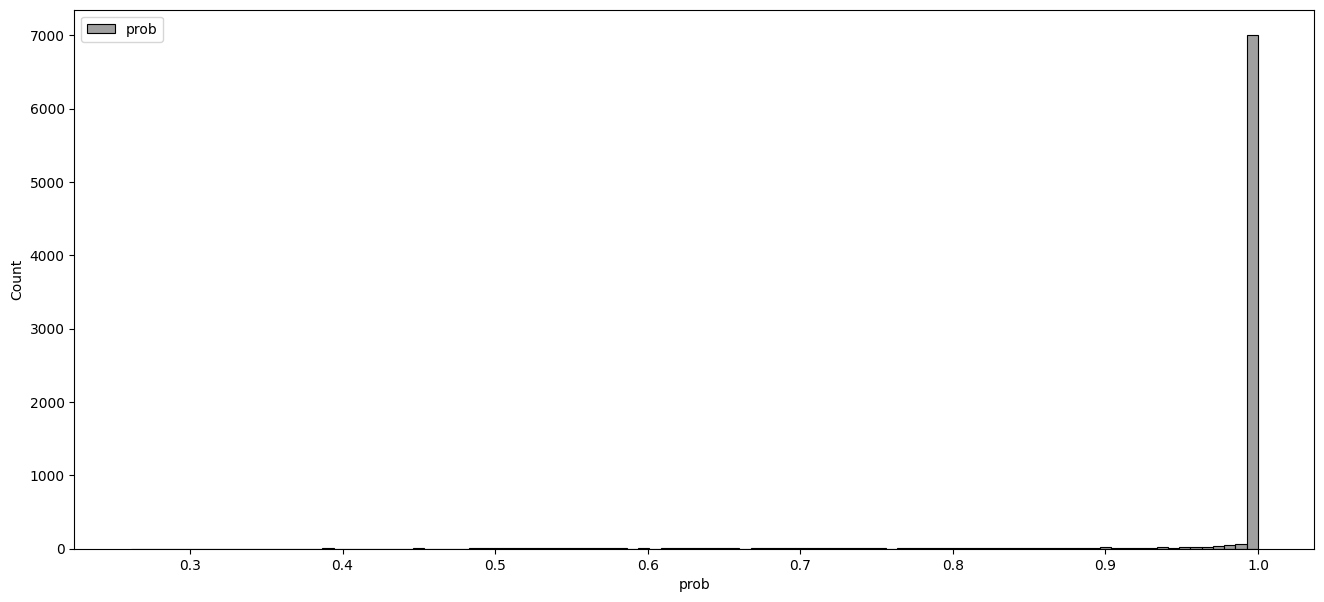

In [16]:
plt.rcParams['figure.figsize'] = [16, 7]
sns.histplot(df["train_test"]['prob'],
             color="gray", label="prob", bins=100)
plt.legend() 
plt.show()


- видим что есть маловероятные предсказани - это внекатегорийные строки, их нужно отсечь
- видим что основная доля ответов в диапазоне от 0.9 до 1

In [17]:
#df["filt"] = df["train_test"]
#установим приемлемую вероятность
df["filt"] = df["train_test"][df["train_test"]['prob'] > 0.9]

precision, recall, f1score = precision_recall_fscore_support(df["filt"]['category'],
                                                             df["filt"]['pred'], average='macro')[:3]
print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')


precision: 0.8684050782903969, recall: 0.8686437352294385, f1score: 0.8684434405813347


### result

в результате внекатегориальные ответы следует оставить пустыми

In [18]:
df["res"] = pd.DataFrame(df["test"]['oid'].copy())

df["res"][['category', 'prob']] = [classifier.predict(t, proba=True) for t in list(df["test"]['text'])]


In [19]:
df["res"]['prob'][df["res"]['prob'] < 0.9].count() / df["res"]['category'].count()

0.05316070068545316

чут больше 5% предсказаний оставим пустыми

сперва преобразуем категории

In [20]:
df["res"]['category'] = df["res"]['category'].apply(lambda x: keys_target[x])
df["res"].loc[df["res"]['prob'] < 0.9, 'category'] = ''

In [21]:
df["res"].head()

,oid,category,prob
0,749208109,martial_arts,0.995541
1,452466036,winter_sport,0.999996
2,161038103,martial_arts,0.993356
3,663621910,esport,0.999986
4,566255305,tennis,1.000000


осталось удалить вероятности

In [22]:
df["res"] = df["res"].drop('prob', axis=1)

df["res"].to_csv('./subsets/VK_Cup_2022_quali/res.csv', index=False)

df["res"].head()


,oid,category
0,749208109,martial_arts
1,452466036,winter_sport
2,161038103,martial_arts
3,663621910,esport
4,566255305,tennis


со значением отсечения по веростности можно было поэкспериментировать, добиваясь лучшего результата при отправке на проверку. <br /> так же можно взять более сложную и точную модель, в нашем примере использована самая лёгкая и быстрая rubert-tiny